# Preparación de datos

Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, initializers

from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Dataset

In [ ]:
df= pd.read_excel ('/content/output.xlsx')
df_participante = df[df['Early Bird/ Participante'] == 'Participante']
df_participante = df_participante.drop ( ['Unnamed: 0', 'mail', 'Nombre ', 'DNI', 'Early Bird/ Participante'], axis= 1)

Feature engineering

In [ ]:
#si nos escribieron una motivacion es 1. Si la dejaron en blanco, es 0.
df_participante.loc[df_participante['motivacion'].notna(),'motivacion']=1
df_participante['motivacion'] = df_participante['motivacion'].fillna(0)

#si no aceptaron los tyc (que por error estaban opcional) entonces cero. Si si, entonces 1. 
df_participante.loc[df_participante['tyc'].notna(),'tyc']=1
df_participante['tyc'] = df_participante['tyc'].fillna(0)

#Mismo criterio para mayoria de edad.
df_participante['mayor'] = df_participante['mayor'].fillna('sí')
df_participante['mayor'] = df_participante['mayor'].replace('sí',1)
df_participante['mayor'] = df_participante['mayor'].replace('no',0)

#Sexo. Mismo criterio, lo vuelvo binario. Respeto lo que parece ser la nombre por si luego quiero hacer stacking> Male==1, Female == 0
df_participante['Sexo'] = df_participante['Sexo'].replace('H',1)
df_participante['Sexo'] = df_participante['Sexo'].replace('M',0)

# Si tiene experiencia con lo que vamos a enseñar. 
df_participante['tiene_cripto'] = df_participante['tiene_cripto'].replace('si',1)
df_participante['tiene_cripto'] = df_participante['tiene_cripto'].replace('no',0)

# Relleno los blancos con el bin mayoritario. 
df_participante['proxyedad'] = df_participante['proxyedad'].fillna('18-24')
df_participante['proxyedad'] = df_participante['proxyedad'].astype(str) 

# Si participaron o no dependera si hicieron alguna actividad alguno de los dias. 
def conditions(df):
    if pd.isna(df['product_defiant']) and pd.isna(df['dificultMOC']) and pd.isna(df['productKrypton']) and pd.isna(df['Eval_CR']):
        return 0
    elif pd.notnull (df['product_defiant']) or pd.notnull(df['dificultMOC']) or pd.notnull(df['productKrypton']) or pd.notnull(df['Eval_CR']):
        return 1
    else:
        return 0
        
df_participante['activo'] = df_participante.apply(conditions, axis=1)

#Sólo dejo representados los paises que mas alumnos aportaron. 
def pais_transform(df):
  if df['pais']== 'argentina':
    return "argentina"
  elif df['pais']== 'colombia':
    return 'colombia' 
  elif df['pais']== 'mexico':
    return 'mexico'
  elif df['pais']== 'venezuela':
    return 'venezuela' 
  else:
    return 'otro'
df_participante['pais_tr'] = df_participante.apply(pais_transform, axis=1)
df_participante.drop (columns='pais', axis=1, inplace=True)

#Calculo la cantidad de dias que pasaron entre que se inscribió el alumno y el primer dia de clases. 
df_participante[['timestamp']] = df_participante[['timestamp']].apply(pd.to_datetime) 
df_participante['days_to_class1'] = (pd.Timestamp('2022-03-07') - df_participante['timestamp']).dt.days

df = df_participante

Pre-processing

In [ ]:
## Binarize binary variables
df_enc = df.copy()
binary_vars = ['Sexo', 'motivacion', 'tyc', 'mayor',
               'tiene_cripto','activo']
enc = LabelEncoder()
df_enc[binary_vars] = df_enc[binary_vars].apply(enc.fit_transform)

## One-hot encode multi-category cat. variables
multicat_vars = ['publicidad', 'conocimientos_previos', 'proxyedad', 'pais_tr', 'days_to_class1']
df_enc = pd.get_dummies(df_enc, columns = multicat_vars)
df_enc.iloc[:,12:50] = df_enc.iloc[:,12:50].astype(int)
#print(df_enc.info())

df_enc.drop(['timestamp', 'product_defiant', 'dificultMOC', 'productKrypton','productTropykus','Eval_CR'], axis=1, inplace= True)

In [ ]:
X = df_enc.drop('activo', axis = 1)
y= df_enc['activo']

print('Original dataset shape %s' % Counter(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2,stratify = y, random_state = 30)

Original dataset shape Counter({0: 532, 1: 189})


Utils

In [ ]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
# function to plot train and validation over epochs
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# Arquitectura 1. 

In [ ]:
input_len = X_test.shape[1]
input_len

43

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 43)                1892      
                                                                 
 dense_1 (Dense)             (None, 2)                 88        
                                                                 
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
18/18 [==============================] - 2s 40ms/step - loss: 0.6717 - accuracy: 0.7188 - precision: 0.2622 - recall: 1.0000 - val_loss: 0.6452 - val_accuracy: 0.7379 - val_precision: 0.2596 - val_recall: 1.0000
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.6163 - accuracy: 0.7378 - precision: 0.2622 - recall: 1.0000 - val_loss: 0.5903 - val_accuracy: 0.7379 - val_precision: 0.2596 - val_recall: 1.0000
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 0.5768 - accuracy: 0.7378 - precision: 0.2622 - recall: 1.0000 - val_loss: 0.5802 - val_accuracy: 0.7379 - val_precision: 0.2596 - val_recall: 1.0000
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 0.5721 - accuracy: 0.7378 - precision: 0.2622 - recall: 1.0000 - val_loss: 0.5794 - val_accuracy: 0.7379 - val_precision: 0.2596 - val_recall: 1.0000
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 0.5667 - accuracy: 0.7378 - precis

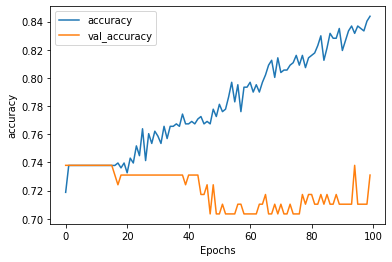

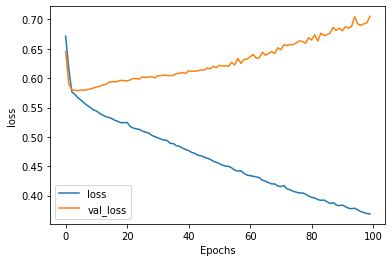

In [ ]:
def make_model(output_bias=None): 
    # create model
    model = Sequential()
    model.add(Dense(units = input_len
                    , input_dim = input_len
                    , kernel_initializer='normal'
                    , activation='relu'))

    if output_bias is not None:
        output_bias = initializers.Constant(output_bias)
    else:
        output_bias = 'zeros'
    model.add(Dense(len(df_enc['activo'].unique())
                    , activation = 'softmax'
                    , kernel_initializer = 'random_uniform'
                    , bias_initializer = output_bias))
    
    # Compile model
    optimizer = keras.optimizers.Adam(lr=1e-3)
    model.compile(optimizer = optimizer
                  , loss = 'sparse_categorical_crossentropy'
                  , metrics = ['accuracy', precision, recall])
    
    return model

model = make_model()
model.summary()

history = model.fit (X_train, y_train, epochs=100, validation_data=(X_test,  y_test))

y_arc1_pred = model.predict(X_test)
y_arc1_pred=np.argmax(y_arc1_pred,axis=1)

print(classification_report(y_test , y_arc1_pred))
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, y_arc1_pred)}')
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

Tratamiento del problema de desbalanceo
- Set initial bias

bias set to [-1.034896474282002, 0]
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


18/18 [==============================] - 1s 29ms/step - loss: 1.0011 - accuracy: 0.2622 - precision: 0.2622 - recall: 1.0000 - val_loss: 0.9097 - val_accuracy: 0.2621 - val_precision: 0.2596 - val_recall: 1.0000
Epoch 2/100
18/18 [==============================] - 0s 8ms/step - loss: 0.7995 - accuracy: 0.2986 - precision: 0.2622 - recall: 1.0000 - val_loss: 0.6760 - val_accuracy: 0.6483 - val_precision: 0.2596 - val_recall: 1.0000
Epoch 3/100
18/18 [==============================] - 0s 12ms/step - loss: 0.6153 - accuracy: 0.7292 - precision: 0.2622 - recall: 1.0000 - val_loss: 0.5845 - val_accuracy: 0.7379 - val_precision: 0.2596 - val_recall: 1.0000
Epoch 4/100
18/18 [==============================] - 0s 12ms/step - loss: 0.5791 - accuracy: 0.7378 - precision: 0.2622 - recall: 1.0000 - val_loss: 0.5847 - val_accuracy: 0.7379 - val_precision: 0.2596 - val_recall: 1.0000
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 0.5721 - accuracy: 0.7378 - precision: 0.262

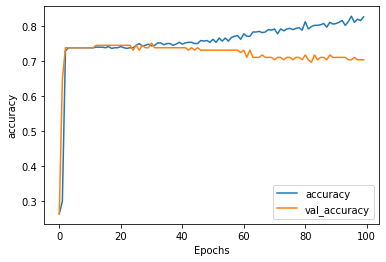

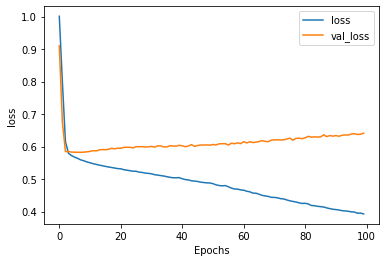

In [ ]:
undersampled = df_enc[df_enc['activo'] == 1.0]['activo'].count()
oversampled = df_enc[df_enc['activo'] == 0.0]['activo'].count()

# this is an standard [Miller (1984)]
initial_bias = np.log([undersampled/oversampled])[0] #ver esto como hacer el tema de los pesos. 
initial_bias = [initial_bias, 0]
# if error, remove "[0]". This is probably because of version
print('bias set to ' + str(initial_bias))

# create a biased model affecting the bias to the last layer
bias_model = make_model (output_bias = initial_bias)
history_bias = bias_model.fit(X_train, y_train, epochs=100, validation_data=(X_test,  y_test))

y_bias_pred = bias_model.predict(X_test)

y_bias_pred=np.argmax(y_bias_pred,axis=1)

print(classification_report(y_test , y_bias_pred))
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, y_bias_pred)}')
plot_graphs(history_bias, 'accuracy')
plot_graphs(history_bias, 'loss')

- Set a class weight

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


18/18 [==============================] - 1s 16ms/step - loss: 0.5272 - accuracy: 0.7292 - precision: 0.2622 - recall: 1.0000 - val_loss: 0.6248 - val_accuracy: 0.7379 - val_precision: 0.2596 - val_recall: 1.0000
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 0.4129 - accuracy: 0.7378 - precision: 0.2622 - recall: 1.0000 - val_loss: 0.5824 - val_accuracy: 0.7379 - val_precision: 0.2596 - val_recall: 1.0000
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 0.3160 - accuracy: 0.7378 - precision: 0.2622 - recall: 1.0000 - val_loss: 0.6432 - val_accuracy: 0.7379 - val_precision: 0.2596 - val_recall: 1.0000
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 0.2925 - accuracy: 0.7378 - precision: 0.2622 - recall: 1.0000 - val_loss: 0.6861 - val_accuracy: 0.7379 - val_precision: 0.2596 - val_recall: 1.0000
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 0.2911 - accuracy: 0.7378 - precision: 0.2622 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


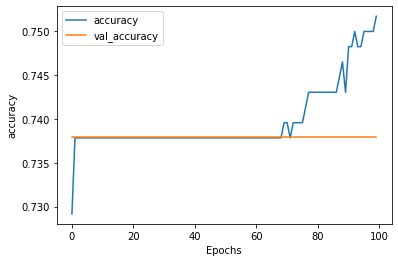

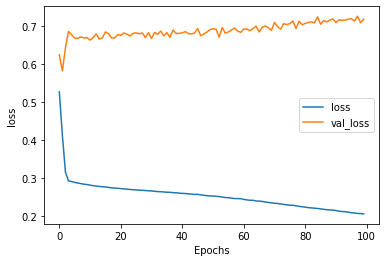

In [ ]:
class_weight = {'no_activo':0., 'activo':1.}
class_weight = {0:1., 1:0.35}  

# create a biased balancing class weights
classweight_model = make_model()
history_classweight = classweight_model.fit(X_train, y_train, epochs=100, validation_data=(X_test,  y_test), class_weight = class_weight)

y_classweight_pred = classweight_model.predict(X_test)
y_classweight_pred=np.argmax(y_classweight_pred,axis=1)

print(classification_report(y_test , y_classweight_pred))
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, y_classweight_pred)}')
plot_graphs(history_classweight, 'accuracy')
plot_graphs(history_classweight, 'loss')

- Balance the classes in the training set

In [ ]:
df_enc_copy = df_enc.copy()

li = []
for i in range(1,3):
    x = df_enc_copy[df_enc_copy['activo'] == 1]
    li.append(x)

li.append(df_enc_copy)
    
df_enc_copy = pd.concat(li, axis=0, ignore_index=True)
X = df_enc_copy.drop('activo', axis = 1)
y= df_enc_copy['activo']

from collections import Counter
print('Original dataset shape %s' % Counter(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2,stratify = y, random_state = 30)

Original dataset shape Counter({1: 567, 0: 532})


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 1s 13ms/step - loss: 0.6920 - accuracy: 0.5233 - precision: 0.5170 - recall: 1.0000 - val_loss: 0.6897 - val_accuracy: 0.5500 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 2/100
28/28 [==============================] - 0s 3ms/step - loss: 0.6871 - accuracy: 0.5802 - precision: 0.5170 - recall: 1.0000 - val_loss: 0.6861 - val_accuracy: 0.5500 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6813 - accuracy: 0.5745 - precision: 0.5182 - recall: 1.0000 - val_loss: 0.6809 - val_accuracy: 0.5591 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 4/100
28/28 [==============================] - 0s 3ms/step - loss: 0.6734 - accuracy: 0.5825 - precision: 0.5106 - recall: 1.0000 - val_loss: 0.6765 - val_accuracy: 0.6000 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6662 - accuracy: 0.6075 - precision: 0.5182 

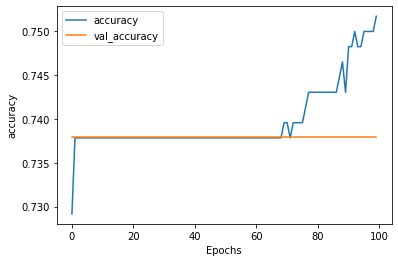

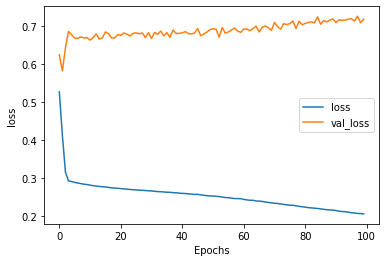

In [ ]:
balance_model = make_model()
history_balanced = balance_model.fit (X_train, y_train, epochs=100, validation_data=(X_test,  y_test))

y_balance_pred = balance_model.predict(X_test)
y_balance_pred=np.argmax(y_balance_pred,axis=1)

print(classification_report(y_test , y_balance_pred))
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, y_balance_pred)}')
plot_graphs(history_classweight, 'accuracy')
plot_graphs(history_classweight, 'loss')

**Se requiere una búsqueda de hiperparámetros**

Elijo hacer una búsqueda de la cantidad de capas densas. Es uno de los cambios que puede tener más impacto en el resultado. 

Mido el impacto por curva ROC dado que (a pesar que lo entreno con un dataset balanceado) mi test está desbalanceado y mi objetivo es que tenga buenos resultados en test. 

In [ ]:
def make_model_2(dense_layers = 1, dense_dropout = 0.0, lr = 1e-3, output_bias=None):
    # create model
    model = Sequential()
    for i in range(0,dense_layers):
      model.add(Dense(units = input_len
                      , input_dim = input_len
                      , kernel_initializer='normal'
                      , activation='relu'))
      if dense_dropout != 0.0:
        model.add(Dropout(dense_dropout)) # regularization
    
    if output_bias is not None:
        output_bias = initializers.Constant(output_bias)
    else:
        output_bias = 'zeros'
    model.add(Dense(len(df_enc['activo'].unique())
                    , activation = 'softmax'
                    , kernel_initializer = 'random_uniform'
                    , bias_initializer = output_bias))
    
    # Compile model
    optimizer = keras.optimizers.Adam(lr=lr)
    model.compile(optimizer = optimizer
                  , loss = 'sparse_categorical_crossentropy'
                  , metrics = ['accuracy', precision, recall])
        
    return model

model = make_model_2()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 43)                1892      
                                                                 
 dense_9 (Dense)             (None, 2)                 88        
                                                                 
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Proposed 7 models
Dense layers: 1
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 1s 11ms/step - loss: 0.6920 - accuracy: 0.5438 - precision: 0.5195 - recall: 1.0000 - val_loss: 0.6902 - val_accuracy: 0.5364 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 2/100
28/28 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.5290 - precision: 0.5170 - recall: 1.0000 - val_loss: 0.6863 - val_accuracy: 0.5500 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 3/100
28/28 [==============================] - 0s 3ms/step - loss: 0.6816 - accuracy: 0.5802 - precision: 0.5182 - recall: 1.0000 - val_loss: 0.6818 - val_accuracy: 0.5682 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 4/100
28/28 [==============================] - 0s 3ms/step - loss: 0.6756 - accuracy: 0.5757 - precision: 0.5157 - recall: 1.0000 - val_loss: 0.6767 - val_accuracy: 0.5682 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/100
28/28 [==============================] - 0s 3ms/step - loss: 0.6669 - accuracy: 0.5859 - precision: 0.5144 

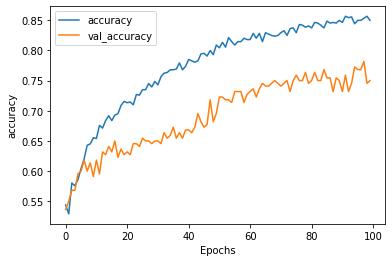

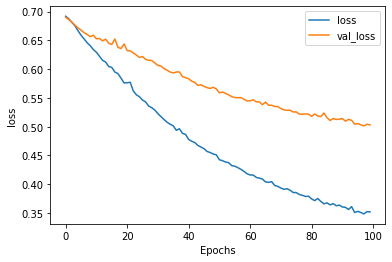

Dense layers: 2
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 1s 11ms/step - loss: 0.6927 - accuracy: 0.5233 - precision: 0.5157 - recall: 1.0000 - val_loss: 0.6921 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 2/100
28/28 [==============================] - 0s 3ms/step - loss: 0.6907 - accuracy: 0.5165 - precision: 0.5094 - recall: 1.0000 - val_loss: 0.6894 - val_accuracy: 0.5227 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6859 - accuracy: 0.5779 - precision: 0.5144 - recall: 1.0000 - val_loss: 0.6849 - val_accuracy: 0.5273 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6768 - accuracy: 0.5870 - precision: 0.5144 - recall: 1.0000 - val_loss: 0.6768 - val_accuracy: 0.5545 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/100
28/28 [==============================] - 0s 3ms/step - loss: 0.6622 - accuracy: 0.6030 - precision: 0.5170 

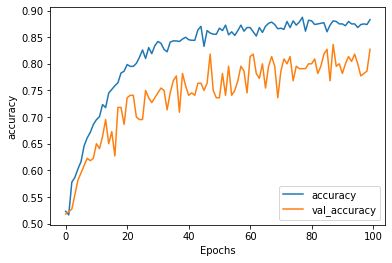

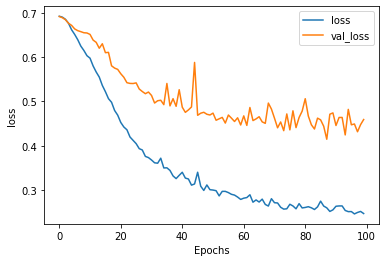

Dense layers: 3
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 1s 12ms/step - loss: 0.6932 - accuracy: 0.5097 - precision: 0.5208 - recall: 1.0000 - val_loss: 0.6924 - val_accuracy: 0.5227 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 2/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5370 - precision: 0.5195 - recall: 1.0000 - val_loss: 0.6892 - val_accuracy: 0.5227 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6855 - accuracy: 0.5540 - precision: 0.5144 - recall: 1.0000 - val_loss: 0.6781 - val_accuracy: 0.5773 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6643 - accuracy: 0.6098 - precision: 0.5157 - recall: 1.0000 - val_loss: 0.6621 - val_accuracy: 0.6091 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6469 - accuracy: 0.6337 - precision: 0.5195 

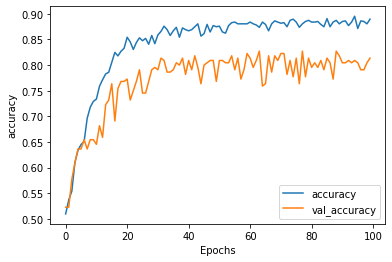

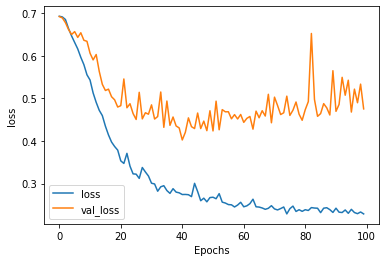

Dense layers: 4
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 1s 12ms/step - loss: 0.6932 - accuracy: 0.4846 - precision: 0.5157 - recall: 1.0000 - val_loss: 0.6930 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 2/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5154 - precision: 0.5157 - recall: 1.0000 - val_loss: 0.6908 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6872 - accuracy: 0.5415 - precision: 0.5151 - recall: 0.9978 - val_loss: 0.6840 - val_accuracy: 0.5273 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6751 - accuracy: 0.5779 - precision: 0.5170 - recall: 1.0000 - val_loss: 0.6759 - val_accuracy: 0.5773 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6674 - accuracy: 0.5995 - precision: 0.5170 

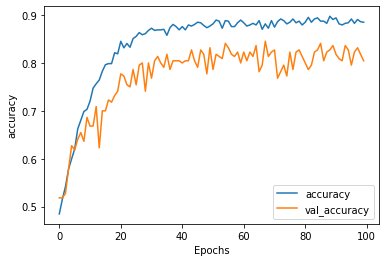

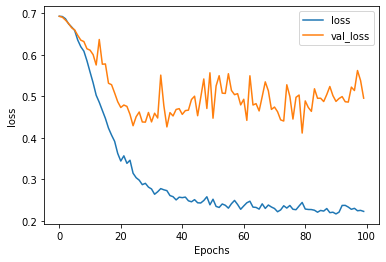

Dense layers: 5
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 1s 13ms/step - loss: 0.6932 - accuracy: 0.4903 - precision: 0.5132 - recall: 1.0000 - val_loss: 0.6931 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 2/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5154 - precision: 0.5170 - recall: 1.0000 - val_loss: 0.6929 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5154 - precision: 0.5144 - recall: 1.0000 - val_loss: 0.6921 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5518 - precision: 0.5157 - recall: 1.0000 - val_loss: 0.6840 - val_accuracy: 0.5955 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6678 - accuracy: 0.6052 - precision: 0.5170 

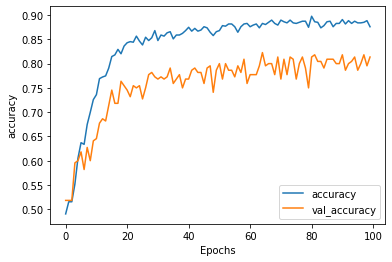

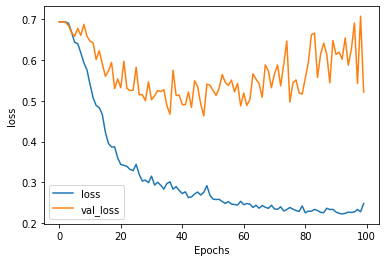

Dense layers: 6
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 1s 13ms/step - loss: 0.6932 - accuracy: 0.5006 - precision: 0.5132 - recall: 1.0000 - val_loss: 0.6930 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 2/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5154 - precision: 0.5157 - recall: 1.0000 - val_loss: 0.6930 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 3/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5154 - precision: 0.5132 - recall: 1.0000 - val_loss: 0.6928 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 4/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5154 - precision: 0.5119 - recall: 1.0000 - val_loss: 0.6926 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.5154 - precision: 0.5132 

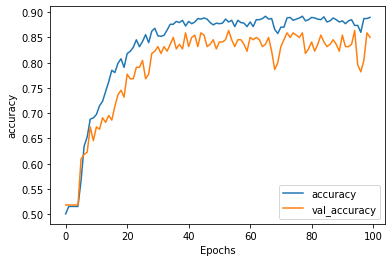

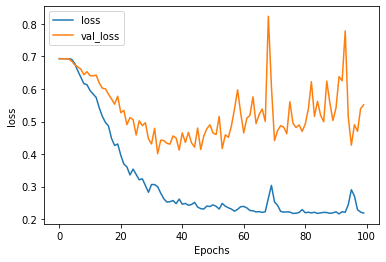

Dense layers: 7
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4858 - precision: 0.5144 - recall: 1.0000 - val_loss: 0.6930 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 2/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5154 - precision: 0.5182 - recall: 1.0000 - val_loss: 0.6928 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5154 - precision: 0.5182 - recall: 1.0000 - val_loss: 0.6928 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5154 - precision: 0.5170 - recall: 1.0000 - val_loss: 0.6926 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5154 - precision: 0.5170 

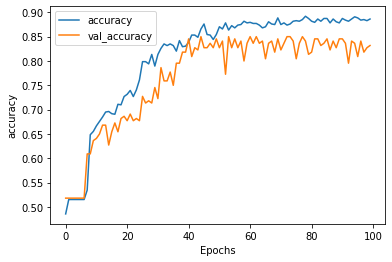

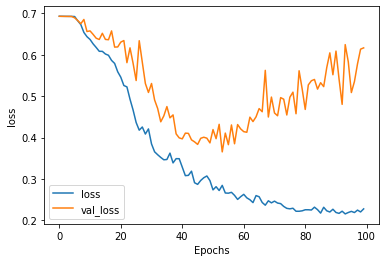

In [ ]:
dense_layers = range (1,8)

import itertools

param_grid = dict(dense_layers = dense_layers)

keys = param_grid.keys()
values = (param_grid[key] for key in keys)
param_grid = [dict(zip(keys, param_grid)) for param_grid in itertools.product(*values)]

print('Proposed ' + str(len(param_grid)) + ' models')

for j in range(0, len(param_grid)):
    
    dense_layers = param_grid[j].get("dense_layers")
    print (f'Dense layers: '+ str(dense_layers))

    model = make_model_2 (dense_layers = dense_layers)
    
    
    history = model.fit(X_train, 
                        y_train,
                        epochs = 100,
                        validation_data = (X_test, y_test), 
                        verbose = 1)
    
    y_balance_pred = model.predict(X_test)
    y_balance_pred=np.argmax(y_balance_pred,axis=1)
    print(classification_report(y_test , y_balance_pred))
    roc_test = roc_auc_score(y_test, y_balance_pred)
    print(f'Test ROC AUC  Score: '+ str (roc_test))
    plot_graphs(history, 'accuracy')
    plot_graphs(history, 'loss')
    acc = pd.DataFrame.from_dict(history.history)['accuracy'].iloc[-1]
    param_grid[j].update( {"acc":acc})
    param_grid[j].update ({'roc': roc_test})
    
results = pd.DataFrame(param_grid)

In [ ]:
results.sort_values(['roc'],ascending = False)

,dense_layers,acc,roc
5,6,0.889647,0.845995
6,7,0.886234,0.825803
1,2,0.882821,0.822741
2,3,0.889647,0.811238
4,5,0.875995,0.810245
3,4,0.885097,0.801142
0,1,0.849829,0.748841


Mi modelo tendrá 6 capas densas.

**Una vez elegido un modelo, hacer un grid search cambiando únicamente uno de los hyper parámetros. Estudiar cuál es su efecto y comprobar que sea el esperado a corde a los notebooks vistos en clase "nn_architecture". Se requiere estudiar 3 parámetros (learning rate, batch size, drop_out, activaciones, escalado de variables, etc. a elegir 3).**

Elijo hacer una busqueda hiperparámetros de drop_out, las activaciones y el learning rate. El desarrollo sigue a continuación:

- Drop out

In [ ]:
def make_model_3(dense_layers = 6, dense_dropout = 0.0, lr = 1e-3, output_bias=None):
    # create model
    model = Sequential()
    for i in range(0,dense_layers):
      model.add(Dense(units = input_len
                      , input_dim = input_len
                      , kernel_initializer='normal'
                      , activation='relu'))
      if dense_dropout != 0.0:
        model.add(Dropout(dense_dropout)) # regularization
    
    if output_bias is not None:
        output_bias = initializers.Constant(output_bias)
    else:
        output_bias = 'zeros'
    model.add(Dense(len(df_enc['activo'].unique())
                    , activation = 'softmax'
                    , kernel_initializer = 'random_uniform'
                    , bias_initializer = output_bias))
    
    # Compile model
    optimizer = keras.optimizers.Adam(lr=lr)
    model.compile(optimizer = optimizer
                  , loss = 'sparse_categorical_crossentropy'
                  , metrics = ['accuracy', precision, recall])
        
    return model

model = make_model_3()
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 43)                1892      
                                                                 
 dense_46 (Dense)            (None, 43)                1892      
                                                                 
 dense_47 (Dense)            (None, 43)                1892      
                                                                 
 dense_48 (Dense)            (None, 43)                1892      
                                                                 
 dense_49 (Dense)            (None, 43)                1892      
                                                                 
 dense_50 (Dense)            (None, 43)                1892      
                                                                 
 dense_51 (Dense)            (None, 2)               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
dense_dropout = [0.0,0.3,0.5,0.7]

Proposed 4 models
Dense dropout: 0.0
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 1s 13ms/step - loss: 0.6932 - accuracy: 0.5119 - precision: 0.5144 - recall: 1.0000 - val_loss: 0.6928 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 2/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5154 - precision: 0.5144 - recall: 1.0000 - val_loss: 0.6927 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5154 - precision: 0.5119 - recall: 1.0000 - val_loss: 0.6900 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6808 - accuracy: 0.5154 - precision: 0.5132 - recall: 1.0000 - val_loss: 0.6792 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6657 - accuracy: 0.6200 - precision: 0.5157 

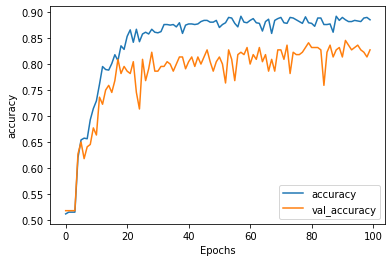

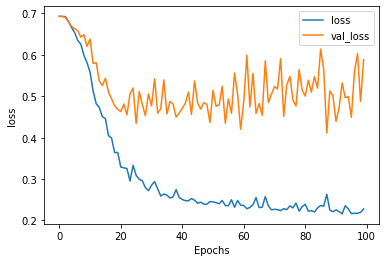

Dense dropout: 0.3
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 2s 29ms/step - loss: 0.6935 - accuracy: 0.4846 - precision: 0.5144 - recall: 1.0000 - val_loss: 0.6932 - val_accuracy: 0.4818 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 2/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.4994 - precision: 0.5157 - recall: 1.0000 - val_loss: 0.6930 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5154 - precision: 0.5157 - recall: 1.0000 - val_loss: 0.6928 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5154 - precision: 0.5208 - recall: 1.0000 - val_loss: 0.6928 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5154 - precision: 0.5182 

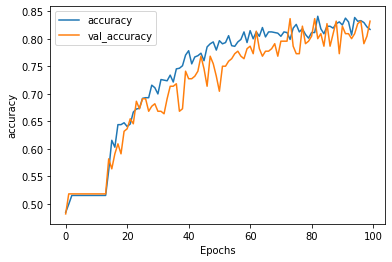

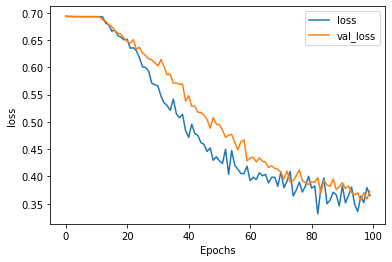

Dense dropout: 0.5
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 1s 13ms/step - loss: 0.6933 - accuracy: 0.4869 - precision: 0.5170 - recall: 1.0000 - val_loss: 0.6929 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 2/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5154 - precision: 0.5106 - recall: 1.0000 - val_loss: 0.6927 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 3/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.5154 - precision: 0.5144 - recall: 1.0000 - val_loss: 0.6927 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 4/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5154 - precision: 0.5208 - recall: 1.0000 - val_loss: 0.6927 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5154 - precision: 0.5144 

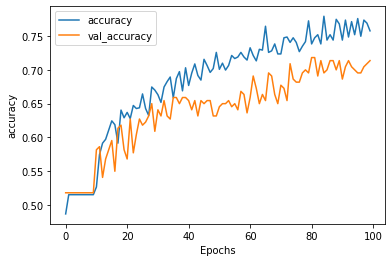

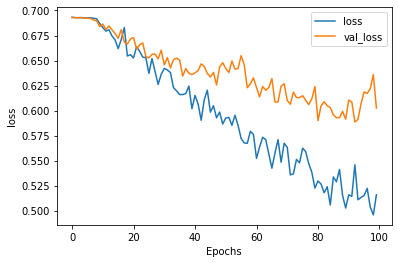

Dense dropout: 0.7
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 1s 13ms/step - loss: 0.6934 - accuracy: 0.5085 - precision: 0.5195 - recall: 1.0000 - val_loss: 0.6928 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 2/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.5154 - precision: 0.5144 - recall: 1.0000 - val_loss: 0.6928 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5154 - precision: 0.5157 - recall: 1.0000 - val_loss: 0.6927 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5154 - precision: 0.5182 - recall: 1.0000 - val_loss: 0.6927 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5154 - precision: 0.5144 

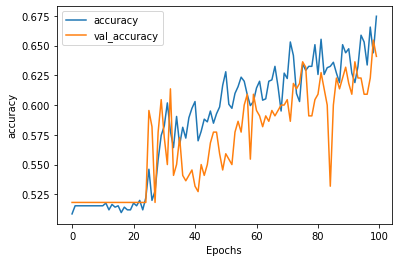

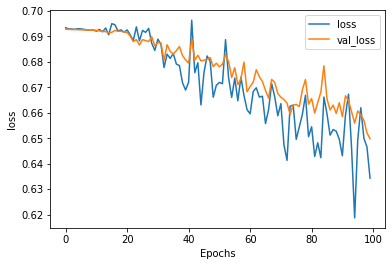

In [ ]:
param_grid = dict(dense_dropout = dense_dropout)

keys = param_grid.keys()
values = (param_grid[key] for key in keys)
param_grid = [dict(zip(keys, param_grid)) for param_grid in itertools.product(*values)]

print('Proposed ' + str(len(param_grid)) + ' models')

for j in range(0, len(param_grid)):
    
    dense_dropout = param_grid[j].get("dense_dropout")
    print (f'Dense dropout: '+ str (dense_dropout))

    model = make_model_3 (dense_dropout = dense_dropout)
    
    
    history = model.fit(X_train, 
                        y_train,
                        epochs = 100,
                        validation_data = (X_test, y_test), 
                        verbose = 1)
    
    y_balance_pred = model.predict(X_test)
    y_balance_pred=np.argmax(y_balance_pred,axis=1)
    print(classification_report(y_test , y_balance_pred))
    roc_test = roc_auc_score(y_test, y_balance_pred)
    print(f'Test ROC AUC  Score: '+ str (roc_test))
    plot_graphs(history, 'accuracy')
    plot_graphs(history, 'loss')
    acc = pd.DataFrame.from_dict(history.history)['accuracy'].iloc[-1]
    param_grid[j].update( {"acc":acc})
    param_grid[j].update ({'roc': roc_test})
    
results = pd.DataFrame(param_grid)

In [ ]:
results.sort_values(['roc'],ascending = False)

,dense_dropout,acc,roc
1,0.3,0.816837,0.829775
0,0.0,0.885097,0.821086
2,0.5,0.757679,0.712761
3,0.7,0.674630,0.644902


Análisis: 

A medida que aumento capas, aumenta el riesgo de overfitting. Eso lo puedo ver claramente en las curvas al final de cada entrenamiento. 

A partir de incorporar el dropout puedo ver que las lineas no se separan sino que tanto validacion como training van juntas. Eso es lo que queremos lograr. 

- Activations

Para las capas intermedias, pruebo entre Relu y Leaky Relu. Mi hipótesis es que dado que mi dataset tiene varias columnas con muchos ceros talvez el Leaky Relu mejore la performance. Esta hipótesis no se comprueba cuando lo entreno así que mantengo la estructura de relu. 

También modifiqué el initializer a he_normal. Lo comparo con initializers: normal, he_normal y he_uniform, aunque elimino las celdas para que no sea un notebook excesivamente largo. 

In [ ]:
def make_model_4(dense_layers = 6, dense_dropout = 0.3, lr = 1e-3, output_bias=None, activation = 'relu'):
    # create model
    model = Sequential()
    for i in range(0,dense_layers):
      model.add(Dense(units = input_len
                      , input_dim = input_len
                      , kernel_initializer='he_normal'
                      , activation=activation))
      if dense_dropout != 0.0:
        model.add(Dropout(dense_dropout)) # regularization
    
    if output_bias is not None:
        output_bias = initializers.Constant(output_bias)
    else:
        output_bias = 'zeros'
    model.add(Dense(len(df_enc['activo'].unique())
                    , activation = 'softmax'
                    , kernel_initializer = 'random_uniform'
                    , bias_initializer = output_bias))
    
    # Compile model
    optimizer = keras.optimizers.Adam(lr=lr)
    model.compile(optimizer = optimizer
                  , loss = 'sparse_categorical_crossentropy'
                  , metrics = ['accuracy', precision, recall])
        
    return model

model = make_model_4()
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 43)                1892      
                                                                 
 dropout_36 (Dropout)        (None, 43)                0         
                                                                 
 dense_109 (Dense)           (None, 43)                1892      
                                                                 
 dropout_37 (Dropout)        (None, 43)                0         
                                                                 
 dense_110 (Dense)           (None, 43)                1892      
                                                                 
 dropout_38 (Dropout)        (None, 43)                0         
                                                                 
 dense_111 (Dense)           (None, 43)              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
activation = ['relu', 'LeakyReLU']

Proposed 2 models
Activation internal: relu
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 1s 14ms/step - loss: 0.7017 - accuracy: 0.4699 - precision: 0.5170 - recall: 1.0000 - val_loss: 0.6933 - val_accuracy: 0.5318 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 2/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6951 - accuracy: 0.5063 - precision: 0.5132 - recall: 1.0000 - val_loss: 0.6928 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.5006 - precision: 0.5157 - recall: 1.0000 - val_loss: 0.6925 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 4/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.5267 - precision: 0.5157 - recall: 1.0000 - val_loss: 0.6925 - val_accuracy: 0.5136 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5051 - precision: 0.5144 

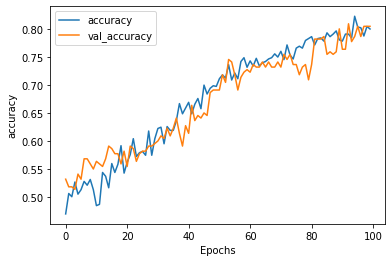

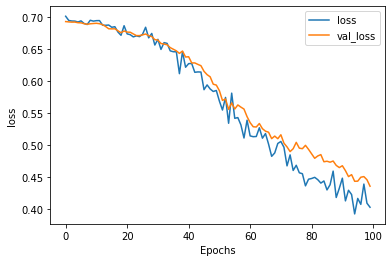

Activation internal: LeakyReLU
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 1s 13ms/step - loss: 0.7103 - accuracy: 0.4846 - precision: 0.5170 - recall: 1.0000 - val_loss: 0.6915 - val_accuracy: 0.5364 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 2/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5461 - precision: 0.5144 - recall: 1.0000 - val_loss: 0.6904 - val_accuracy: 0.5136 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 3/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6884 - accuracy: 0.5370 - precision: 0.5106 - recall: 1.0000 - val_loss: 0.6874 - val_accuracy: 0.5636 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5495 - precision: 0.5170 - recall: 1.0000 - val_loss: 0.6870 - val_accuracy: 0.5864 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6953 - accuracy: 0.5313 - precision: 0.5170 

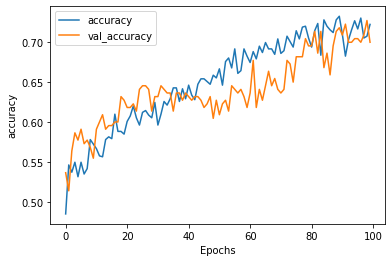

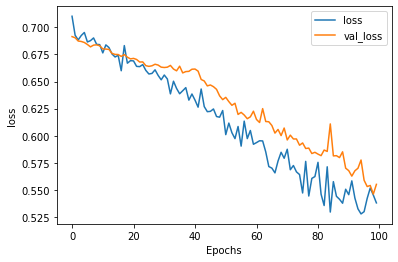

In [ ]:
param_grid = dict(activation = activation)

keys = param_grid.keys()
values = (param_grid[key] for key in keys)
param_grid = [dict(zip(keys, param_grid)) for param_grid in itertools.product(*values)]

print('Proposed ' + str(len(param_grid)) + ' models')

for j in range(0, len(param_grid)):
    
    activation = param_grid[j].get("activation")
    print (f'Activation internal: '+ str (activation))

    model = make_model_4 (activation = activation)
    
    
    history = model.fit(X_train, 
                        y_train,
                        epochs = 100,
                        validation_data = (X_test, y_test), 
                        verbose = 1)
    
    y_balance_pred = model.predict(X_test)
    y_balance_pred=np.argmax(y_balance_pred,axis=1)
    print(classification_report(y_test , y_balance_pred))
    roc_test = roc_auc_score(y_test, y_balance_pred)
    print(f'Test ROC AUC  Score: '+ str (roc_test))
    plot_graphs(history, 'accuracy')
    plot_graphs(history, 'loss')
    acc = pd.DataFrame.from_dict(history.history)['accuracy'].iloc[-1]
    param_grid[j].update( {"acc":acc})
    param_grid[j].update ({'roc': roc_test})
    
results = pd.DataFrame(param_grid)

In [ ]:
results.sort_values(['roc'],ascending = False)

,activation,acc,roc
0,relu,0.799772,0.799156
1,LeakyReLU,0.722412,0.695631


- Activation final.

La última capa es muy importante porque determina el resultado que expondrá el modelo. Dado que es un problema binario tradicionalmente lo trataría con una activación sigmoidea y no tratando cada etiqueta como una categoría en sí misma. 

Sin perjuicio de ello, del análisis que surge del entrenamiento se puede ver que es mejor mantener una activación softmax.

In [ ]:
def make_model_5(dense_layers = 6, dense_dropout = 0.3, lr = 1e-3, output_bias=None, activation = 'softmax'):
    # create model
    model = Sequential()
    for i in range(0,dense_layers):
      model.add(Dense(units = input_len
                      , input_dim = input_len
                      , kernel_initializer='he_normal'
                      , activation='relu'))
      if dense_dropout != 0.0:
        model.add(Dropout(dense_dropout)) # regularization
    
    if output_bias is not None:
        output_bias = initializers.Constant(output_bias)
    else:
        output_bias = 'zeros'
    
    if activation == 'softmax':
      model.add(Dense(len(df_enc['activo'].unique())
                      , activation = 'softmax'
                      , kernel_initializer = 'random_uniform'
                      , bias_initializer = output_bias))
            # Compile model
      optimizer = keras.optimizers.Adam(lr=lr)
      model.compile(optimizer = optimizer
                    , loss = 'sparse_categorical_crossentropy'
                    , metrics = ['accuracy', precision, recall])
    elif activation !='softmax':
      model.add(Dense(1
                      , activation = activation
                      , kernel_initializer = 'random_uniform'
                      , bias_initializer = output_bias))
      
      # Compile model
      optimizer = keras.optimizers.Adam(lr=lr)
      model.compile(optimizer = optimizer
                    , loss = 'binary_crossentropy'
                    , metrics = ['accuracy', precision, recall])
        
    return model

model = make_model_5()
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_129 (Dense)           (None, 43)                1892      
                                                                 
 dropout_54 (Dropout)        (None, 43)                0         
                                                                 
 dense_130 (Dense)           (None, 43)                1892      
                                                                 
 dropout_55 (Dropout)        (None, 43)                0         
                                                                 
 dense_131 (Dense)           (None, 43)                1892      
                                                                 
 dropout_56 (Dropout)        (None, 43)                0         
                                                                 
 dense_132 (Dense)           (None, 43)              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
activation_ = ['sigmoid', 'softmax', 'tanh', 'softplus', 'swish']

Proposed 5 models
Activation final: sigmoid
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 2s 12ms/step - loss: 0.7003 - accuracy: 0.4937 - precision: 0.5022 - recall: 0.7470 - val_loss: 0.6917 - val_accuracy: 0.5227 - val_precision: 0.5320 - val_recall: 0.7210
Epoch 2/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.5267 - precision: 0.5287 - recall: 0.6241 - val_loss: 0.6914 - val_accuracy: 0.5273 - val_precision: 0.5476 - val_recall: 0.5636
Epoch 3/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5108 - precision: 0.5180 - recall: 0.7212 - val_loss: 0.6919 - val_accuracy: 0.5273 - val_precision: 0.5396 - val_recall: 0.6602
Epoch 4/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6900 - accuracy: 0.5404 - precision: 0.5479 - recall: 0.7095 - val_loss: 0.6916 - val_accuracy: 0.4955 - val_precision: 0.5088 - val_recall: 0.8787
Epoch 5/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5210 - precision: 0.5339 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


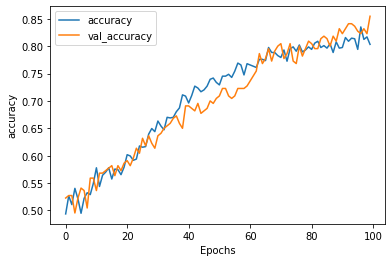

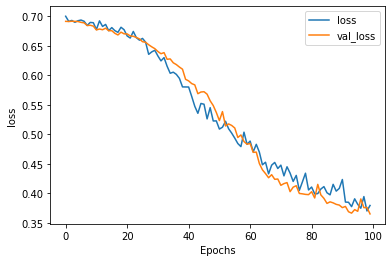

Activation final: softmax
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 1s 13ms/step - loss: 0.7014 - accuracy: 0.4994 - precision: 0.5195 - recall: 1.0000 - val_loss: 0.6921 - val_accuracy: 0.5273 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 2/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6958 - accuracy: 0.4972 - precision: 0.5182 - recall: 1.0000 - val_loss: 0.6926 - val_accuracy: 0.5227 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6977 - accuracy: 0.5074 - precision: 0.5195 - recall: 1.0000 - val_loss: 0.6924 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6955 - accuracy: 0.5074 - precision: 0.5144 - recall: 1.0000 - val_loss: 0.6927 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6940 - accuracy: 0.5131 - precision: 0.5157 

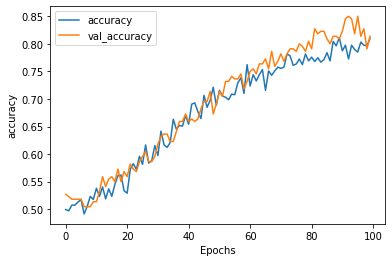

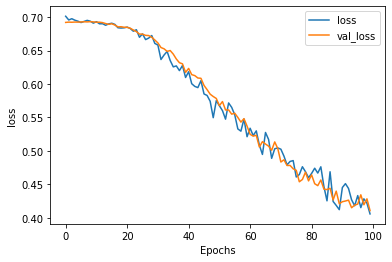

Activation final: tanh
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 1s 14ms/step - loss: 1.2544 - accuracy: 0.4994 - precision: 0.3892 - recall: 0.2339 - val_loss: 0.8072 - val_accuracy: 0.4727 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
28/28 [==============================] - 0s 4ms/step - loss: 0.8038 - accuracy: 0.4949 - precision: 0.5067 - recall: 0.5165 - val_loss: 0.8535 - val_accuracy: 0.4818 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 0.8005 - accuracy: 0.4915 - precision: 0.5259 - recall: 0.3954 - val_loss: 0.8597 - val_accuracy: 0.4818 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 0.7584 - accuracy: 0.5313 - precision: 0.5444 - recall: 0.4899 - val_loss: 0.8596 - val_accuracy: 0.4818 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
28/28 [==============================] - 0s 5ms/step - loss: 0.7824 - accur

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


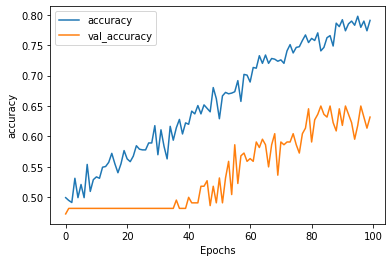

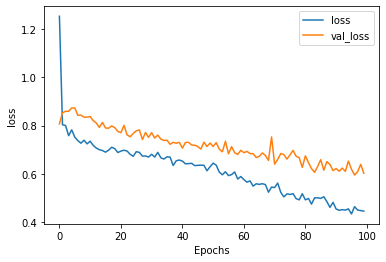

Activation final: softplus
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 1s 14ms/step - loss: 0.7124 - accuracy: 0.5199 - precision: 0.5326 - recall: 0.7826 - val_loss: 0.7092 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 2/100
28/28 [==============================] - 0s 4ms/step - loss: 0.7008 - accuracy: 0.5210 - precision: 0.5230 - recall: 0.6620 - val_loss: 0.7080 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5301 - precision: 0.5413 - recall: 0.6989 - val_loss: 0.7089 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 4/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6993 - accuracy: 0.5188 - precision: 0.5300 - recall: 0.6893 - val_loss: 0.7073 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.5381 - precision: 0.5401 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


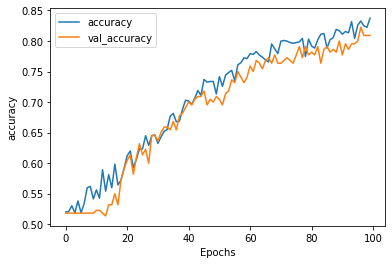

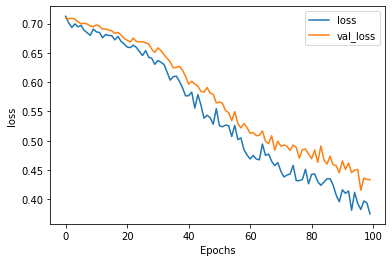

Activation final: swish
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 1s 14ms/step - loss: 2.1953 - accuracy: 0.4858 - precision: 0.3506 - recall: 0.1202 - val_loss: 0.8813 - val_accuracy: 0.4818 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
28/28 [==============================] - 0s 4ms/step - loss: 1.2416 - accuracy: 0.5165 - precision: 0.5558 - recall: 0.3574 - val_loss: 0.8947 - val_accuracy: 0.4818 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 1.0931 - accuracy: 0.5449 - precision: 0.5948 - recall: 0.3811 - val_loss: 0.9337 - val_accuracy: 0.4818 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
28/28 [==============================] - 0s 6ms/step - loss: 1.1197 - accuracy: 0.4949 - precision: 0.5319 - recall: 0.2254 - val_loss: 1.0975 - val_accuracy: 0.4818 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
28/28 [==============================] - 0s 5ms/step - loss: 0.9455 - accur

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


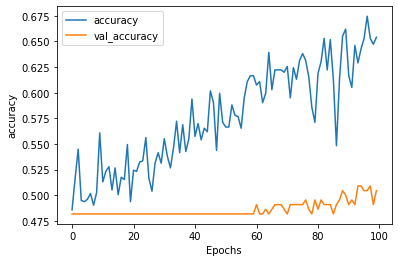

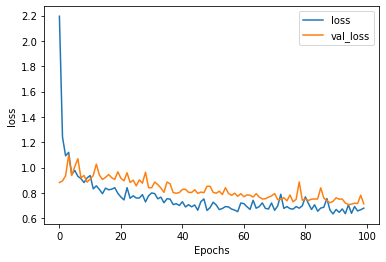

In [ ]:
param_grid = dict(activation = activation_)

keys = param_grid.keys()
values = (param_grid[key] for key in keys)
param_grid = [dict(zip(keys, param_grid)) for param_grid in itertools.product(*values)]

print('Proposed ' + str(len(param_grid)) + ' models')

for j in range(0, len(param_grid)):
    
    activation = param_grid[j].get("activation")
    print (f'Activation final: '+ str (activation))

    model = make_model_5 (activation = activation)
    
    
    history = model.fit(X_train, 
                        y_train,
                        epochs = 100,
                        validation_data = (X_test, y_test), 
                        verbose = 1)
    
    y_balance_pred = model.predict(X_test)
    y_balance_pred=np.argmax(y_balance_pred,axis=1)
    print(classification_report(y_test , y_balance_pred))
    roc_test = roc_auc_score(y_test, y_balance_pred)
    print(f'Test ROC AUC  Score: '+ str (roc_test))
    plot_graphs(history, 'accuracy')
    plot_graphs(history, 'loss')
    acc = pd.DataFrame.from_dict(history.history)['accuracy'].iloc[-1]
    param_grid[j].update( {"acc":acc})
    param_grid[j].update ({'roc': roc_test})
    
results = pd.DataFrame(param_grid)

In [ ]:
results.sort_values(['roc'],ascending = False)

,activation,acc,roc
1,softmax,0.810011,0.809252
0,sigmoid,0.803185,0.500000
2,tanh,0.790671,0.500000
3,softplus,0.837315,0.500000
4,swish,0.654152,0.500000


Del análisis de las múltiples activaciones disponibles y a pesar que este es un problema binario, funciona mejor la activación softmax. 

- Learning rate

Usamos el make_model 4 que viene preparado para recibir estos parámetros. 

In [ ]:
learning_rates = [1e-2, 1e-3, 1e-4]

Proposed 3 models
Learning rate: 0.01
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 1s 14ms/step - loss: 0.7095 - accuracy: 0.5085 - precision: 0.5195 - recall: 1.0000 - val_loss: 0.6922 - val_accuracy: 0.5227 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 2/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6963 - accuracy: 0.5142 - precision: 0.5144 - recall: 1.0000 - val_loss: 0.6923 - val_accuracy: 0.5273 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 3/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5438 - precision: 0.5144 - recall: 1.0000 - val_loss: 0.6909 - val_accuracy: 0.5227 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6896 - accuracy: 0.5336 - precision: 0.5144 - recall: 1.0000 - val_loss: 0.6930 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6867 - accuracy: 0.5836 - precision: 0.5119 

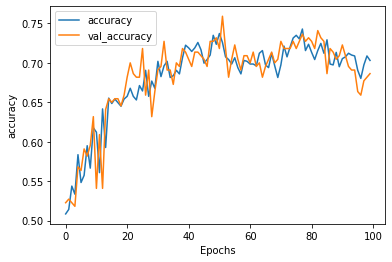

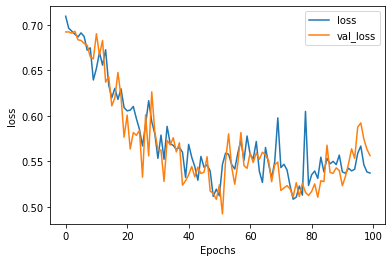

Learning rate: 0.001
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 1s 13ms/step - loss: 0.6997 - accuracy: 0.5074 - precision: 0.5157 - recall: 1.0000 - val_loss: 0.6914 - val_accuracy: 0.5227 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 2/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6997 - accuracy: 0.4960 - precision: 0.5182 - recall: 1.0000 - val_loss: 0.6916 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6974 - accuracy: 0.5290 - precision: 0.5132 - recall: 1.0000 - val_loss: 0.6912 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6972 - accuracy: 0.4915 - precision: 0.5182 - recall: 1.0000 - val_loss: 0.6915 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/100
28/28 [==============================] - 0s 5ms/step - loss: 0.6949 - accuracy: 0.5063 - precision: 0.5119 

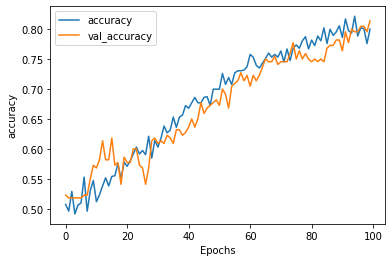

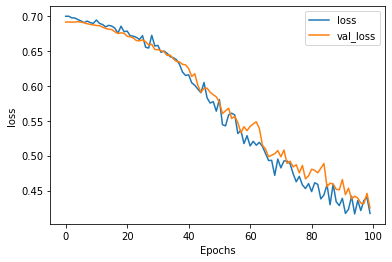

Learning rate: 0.0001
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 2s 13ms/step - loss: 0.7088 - accuracy: 0.5154 - precision: 0.5195 - recall: 1.0000 - val_loss: 0.6923 - val_accuracy: 0.5182 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 2/100
28/28 [==============================] - 0s 4ms/step - loss: 0.7070 - accuracy: 0.5290 - precision: 0.5144 - recall: 1.0000 - val_loss: 0.6923 - val_accuracy: 0.5364 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 3/100
28/28 [==============================] - 0s 5ms/step - loss: 0.7021 - accuracy: 0.4972 - precision: 0.5182 - recall: 1.0000 - val_loss: 0.6923 - val_accuracy: 0.5409 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5484 - precision: 0.5195 - recall: 1.0000 - val_loss: 0.6923 - val_accuracy: 0.5591 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6987 - accuracy: 0.4994 - precision: 0.5182 

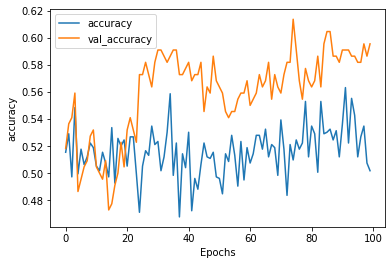

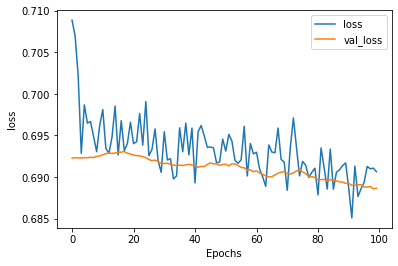

In [ ]:
param_grid = dict(lr = learning_rates)

keys = param_grid.keys()
values = (param_grid[key] for key in keys)
param_grid = [dict(zip(keys, param_grid)) for param_grid in itertools.product(*values)]

print('Proposed ' + str(len(param_grid)) + ' models')

for j in range(0, len(param_grid)):
    
    lr = param_grid[j].get("lr")
    print (f'Learning rate: '+ str (lr))

    model = make_model_4 (lr = lr)
    
    
    history = model.fit(X_train, 
                        y_train,
                        epochs = 100,
                        validation_data = (X_test, y_test), 
                        verbose = 1)
    
    y_balance_pred = model.predict(X_test)
    y_balance_pred=np.argmax(y_balance_pred,axis=1)
    print(classification_report(y_test , y_balance_pred))
    roc_test = roc_auc_score(y_test, y_balance_pred)
    print(f'Test ROC AUC  Score: '+ str (roc_test))
    plot_graphs(history, 'accuracy')
    plot_graphs(history, 'loss')
    acc = pd.DataFrame.from_dict(history.history)['accuracy'].iloc[-1]
    param_grid[j].update( {"acc":acc})
    param_grid[j].update ({'roc': roc_test})
    
results = pd.DataFrame(param_grid)

In [ ]:
results.sort_values(['roc'],ascending = False)

,lr,acc,roc
1,0.0010,0.799772,0.807928
0,0.0100,0.703072,0.674528
2,0.0001,0.501706,0.587471


Un learning rate muy grande puede aprender rapidamente pero nunca converger. Y al revez, un learning rate muy pequeño puede que quede atrapado en un mínimo local o que demore mucho. En ambos casos el resultado es suboptimo. 

Después de la búsqueda de hiperparámetros explorada, el siguiente es un modelo cuya estructura me puede dar buenos resultados. 

In [ ]:
def make_model_final(dense_layers = 6, dense_dropout = 0.3, lr = 1e-3, output_bias=None, input_len = X_test.shape[1]):
    # create model
    model = Sequential()
    for i in range(0,dense_layers):
      model.add(Dense(units = input_len
                      , input_dim = input_len
                      , kernel_initializer='he_normal'
                      , activation='relu'))
      if dense_dropout != 0.0:
        model.add(Dropout(dense_dropout))
    
    if output_bias is not None:
        output_bias = initializers.Constant(output_bias)
    else:
        output_bias = 'zeros'
    model.add(Dense(len(df_enc['activo'].unique())
                    , activation = 'softmax'
                    , kernel_initializer = 'random_uniform'
                    , bias_initializer = output_bias))
    
    # Compile model
    optimizer = keras.optimizers.Adam(lr=lr)
    model.compile(optimizer = optimizer
                  , loss = 'sparse_categorical_crossentropy'
                  , metrics = ['accuracy', precision, recall])
        
    return model

model = make_model_final()
model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_213 (Dense)           (None, 43)                1892      
                                                                 
 dropout_126 (Dropout)       (None, 43)                0         
                                                                 
 dense_214 (Dense)           (None, 43)                1892      
                                                                 
 dropout_127 (Dropout)       (None, 43)                0         
                                                                 
 dense_215 (Dense)           (None, 43)                1892      
                                                                 
 dropout_128 (Dropout)       (None, 43)                0         
                                                                 
 dense_216 (Dense)           (None, 43)              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**Hacer un cambio sobre las las variables (feature engineering) y ver cúal es el efecto sobre el modelo.**

Voy a quitar la columna de dias desde la inscripción hasta el primer día. Esta columna se deriva de contar la cantidad de dias desde la fecha de inscripción que surge en el timestamp de inscripción y la fecha de la primera clase. 
Luego a dicha columna la trato con one hot encoding y por eso se convierten en varias más. 

In [ ]:
df_enc.drop(['days_to_class1_7',
       'days_to_class1_8', 'days_to_class1_9', 'days_to_class1_10',
       'days_to_class1_11', 'days_to_class1_12', 'days_to_class1_13',
       'days_to_class1_14', 'days_to_class1_15', 'days_to_class1_16',
       'days_to_class1_17', 'days_to_class1_18', 'days_to_class1_19',
       'days_to_class1_20', 'days_to_class1_21', 'days_to_class1_22',
       'days_to_class1_23'], axis=1, inplace= True)

In [ ]:
df_enc_copy = df_enc.copy()

li = []
for i in range(1,3):
    x = df_enc_copy[df_enc_copy['activo'] == 1]
    li.append(x)

li.append(df_enc_copy)
    
df_enc_copy = pd.concat(li, axis=0, ignore_index=True)
X = df_enc_copy.drop('activo', axis = 1)
y= df_enc_copy['activo']

from collections import Counter
print('Original dataset shape %s' % Counter(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2,stratify = y, random_state = 30)

Original dataset shape Counter({1: 567, 0: 532})


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


28/28 [==============================] - 3s 30ms/step - loss: 0.7001 - accuracy: 0.4892 - precision: 0.5157 - recall: 1.0000 - val_loss: 0.6930 - val_accuracy: 0.4864 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 2/100
28/28 [==============================] - 0s 15ms/step - loss: 0.7022 - accuracy: 0.4767 - precision: 0.5144 - recall: 1.0000 - val_loss: 0.6926 - val_accuracy: 0.5227 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 3/100
28/28 [==============================] - 0s 11ms/step - loss: 0.6917 - accuracy: 0.5017 - precision: 0.5157 - recall: 1.0000 - val_loss: 0.6927 - val_accuracy: 0.5136 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 4/100
28/28 [==============================] - 0s 11ms/step - loss: 0.6920 - accuracy: 0.5358 - precision: 0.5182 - recall: 1.0000 - val_loss: 0.6925 - val_accuracy: 0.5273 - val_precision: 0.5185 - val_recall: 1.0000
Epoch 5/100
28/28 [==============================] - 0s 13ms/step - loss: 0.6926 - accuracy: 0.5119 - precision: 0.5

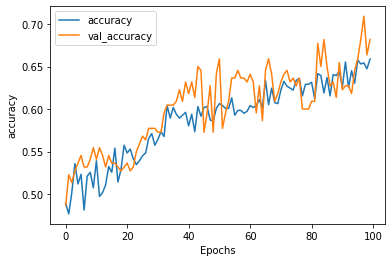

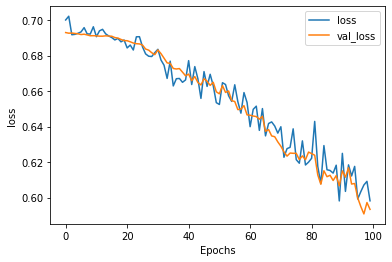

In [ ]:
model = make_model_final(input_len = X_test.shape[1])
  
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test), verbose = 1)
    
y_balance_pred = model.predict(X_test)
y_balance_pred=np.argmax(y_balance_pred,axis=1)
print(classification_report(y_test , y_balance_pred))
roc_test = roc_auc_score(y_test, y_balance_pred)
print(f'Test ROC AUC  Score: '+ str (roc_test))
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

El resultado de la predicción empeora, tanto F1 como ROC. Eso significa que es una columna bastante útil. 

# Arquitectura 2

In [ ]:
# Modelo de base. 
def my_neural_net (dense_layers = 3,
                   dense_dropout = 0.0,
                   lr = 1e-3
                   , verbose = 1
                   , output_bias=None):
   
  model = Sequential()
      # input layer
  for i in range(0,dense_layers):
    model.add(Dense(units = X_train.shape[1]
                    , input_dim = X_train.shape[1], activation='relu')) # dense layers
    if dense_dropout != 0.0:
      model.add(Dropout(dense_dropout)) # regularization
  
  if output_bias is not None:
    output_bias = initializers.Constant(output_bias)
  else:
    output_bias = 'zeros'
  
  model.add(Dense(1, activation='sigmoid')) 
  
  model.compile(loss = 'binary_crossentropy' # return prob dist
                  , optimizer = Adam(lr) # classic classification optimizer
                  , metrics =  ['accuracy', precision, recall])
  if verbose:
    print('dense_layers :' + str(dense_layers))
    print('dense_dropout :' + str(dense_dropout))
    print('lr :' + str(lr))

   
  return model

my_model = my_neural_net()
my_model.summary()

dense_layers :3
dense_dropout :0.0
lr :0.001
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_234 (Dense)           (None, 26)                702       
                                                                 
 dense_235 (Dense)           (None, 26)                702       
                                                                 
 dense_236 (Dense)           (None, 26)                702       
                                                                 
 dense_237 (Dense)           (None, 1)                 27        
                                                                 
Total params: 2,133
Trainable params: 2,133
Non-trainable params: 0
_________________________________________________________________


dense_layers :3
dense_dropout :0.0
lr :0.001
Epoch 1/100
28/28 [==============================] - 1s 12ms/step - loss: 0.7022 - accuracy: 0.4812 - precision: 0.3645 - recall: 0.4040 - val_loss: 0.6936 - val_accuracy: 0.5227 - val_precision: 0.5253 - val_recall: 0.8150
Epoch 2/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.5495 - precision: 0.5601 - recall: 0.6721 - val_loss: 0.6899 - val_accuracy: 0.5364 - val_precision: 0.5349 - val_recall: 0.8224
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6850 - accuracy: 0.5745 - precision: 0.5589 - recall: 0.8264 - val_loss: 0.6880 - val_accuracy: 0.5545 - val_precision: 0.5488 - val_recall: 0.7479
Epoch 4/100
28/28 [==============================] - 0s 4ms/step - loss: 0.6814 - accuracy: 0.5779 - precision: 0.5670 - recall: 0.7185 - val_loss: 0.6847 - val_accuracy: 0.5636 - val_precision: 0.5539 - val_recall: 0.7858
Epoch 5/100
28/28 [==============================] - 0s 4ms/st

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


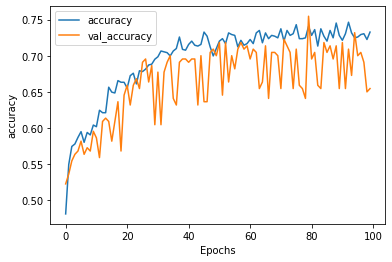

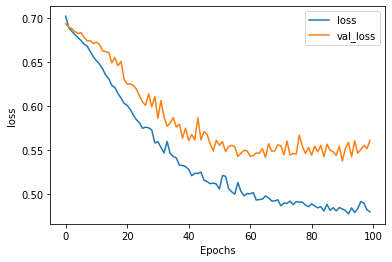

In [ ]:
model = my_neural_net()
  
history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_test, y_test), verbose = 1)
    
y_balance_pred = model.predict(X_test)
y_balance_pred=np.argmax(y_balance_pred,axis=1)
print(classification_report(y_test , y_balance_pred))
roc_test = roc_auc_score(y_test, y_balance_pred)
print(f'Test ROC AUC  Score: '+ str (roc_test))
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

Creo que la mejora sustancial la logro a partir de tomar dos decisiones: 
1. Un oversampling del dataset para equilibrar las clases. Sin perjuicio que reconozco que es un dataset pequeño para tratar con redes neuronales.
2. Tratar este problema binario como de clasificación multivariable con dos outputs y no -como lo venía haciendo en la arquitectura 2 - en un problema binario tradicional.
